# hyperparameter optimization for regression with boston housing

In [3]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

from kerastuner_tensorboard_logger import (
    TensorBoardLogger,
    setup_tb  # Optional
)

from pathlib import Path
import os
import sys
sys.path.insert(1, os.path.dirname(os.getcwd()))
import package.utils as utils
import package.tuning as tuning
utils.check_gpu()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_boston
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2


2.7.0
[INFO] GPU?: <True> [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


### load and describe the dataset
- MEDV is the target variable (median home value)
- other variables can also be used as targets for MIMO regression

In [4]:
boston_dataset = load_boston()
print(boston_dataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

/home/oem/anaconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California h

- the dataset

In [5]:
df = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
df['medv'] = boston_dataset.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,medv
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


- descriptive statistics

In [ ]:
df.describe().transpose()

In [ ]:
df.isna().sum()

### view feature distributions

In [ ]:
utils.plot_feature_distributions(df=df, feature_range=(-1,1), figsize=(12,4))

In [ ]:
sns.pairplot(df, diag_kind='kde')

### split into train, test, and validation
- first remove the target variables from the dataset

In [6]:
y_df = pd.concat([df.pop(x) for x in ['medv', 'PTRATIO']], axis=1)
y_df.head()

,medv,PTRATIO
0,24.0,15.3
1,21.6,17.8
2,34.7,17.8
3,33.4,18.7
4,36.2,18.7


In [7]:
X_train, X_test, y_train, y_test = train_test_split(df, y_df, test_size=.15, random_state=36, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.10, random_state=35, shuffle=True)

### Normalize data to [-1, 1]

In [9]:
scaler = MinMaxScaler(feature_range=(-1,1))
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### Plot feature importances
- xgboost on medv (home value)

In [ ]:
target = y_train['medv']
utils.plot_feature_importance(features=X_train_scaled,
                              feature_labels=X_train.keys(),
                              target=target,
                              target_label=target.name,
                              figsize=(9,4))

- xgboost on student teacher ratio

In [ ]:
target = y_train['PTRATIO']
utils.plot_feature_importance(features=X_train_scaled,
                              feature_labels=X_train.keys(),
                              target=target,
                              target_label=target.name,
                              figsize=(9,4))

In [ ]:
from xgboost import XGBRegressor
target = y_train['medv']
importance_model = XGBRegressor()
importance_model.fit(X_train_scaled, target)

scoring = ['explained_variance',
           'max_error',
           'neg_mean_absolute_error',
           'neg_root_mean_squared_error',
           'r2']

utils.plot_feature_importances(model=importance_model,
                               features=X_train_scaled,
                               feature_labels=X_train.keys(),
                               target=target,
                               target_label=target.name,
                               scoring=scoring)

## Tuners - hyperband

In [78]:
input_shape = (len(X_train.keys()),)
num_outputs = len(y_train.keys())

my_tuning = tuning.Tuning(input_shape, num_outputs)
hyperband = my_tuning.hyperband_search(objective='root_mean_squared_error',
                                       mode='min',
                                       max_epochs=10,
                                       factor=2,
                                       hyperband_iterations=1,
                                       executions_per_trial=3,
                                       hypermodel=my_tuning.create_hypermodel,
                                       directory='logs/hyperband',
                                       project_name='boston_housing',
                                       logger=TensorBoardLogger(
                                            metrics=['root_mean_squared_error'], 
                                            logdir='logs/hyperband/hparams'
                                       ),
                                       X=X_train_scaled,
                                       y=y_train)

hyperband_params = hyperband.get_best_hyperparameters(num_trials=1)[0]
hyperband_model = hyperband.get_best_models()[0]
print(hyperband_params.values)
hyperband_model.summary()

Trial 46 Complete [00h 00m 03s]
root_mean_squared_error: 4.990386009216309

Best root_mean_squared_error So Far: 3.8406410217285156
Total elapsed time: 00h 02m 21s
INFO:tensorflow:Oracle triggered exit
returning model
{'layers': 3, 'units_0': 192, 'units_1': 256, 'units_2': 480, 'units_3': 512, 'dropout_rate': 0.25, 'l2': 0.00025, 'learning_rate': 0.0025, 'batch_size': 32, 'tuner/epochs': 10, 'tuner/initial_epoch': 5, 'tuner/bracket': 3, 'tuner/round': 3, 'tuner/trial_id': 'da0973adafb759349b00293e3ded0d1b'}
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 in1 (InputLayer)            [(None, 12)]              0         
                                                                 
 hidden_0 (Dense)            (None, 192)               2496      
                                                                 
 dropout (Dropout)           (None, 192)               0         
         

## Tuners - randomsearch

In [14]:
randomsearch = my_tuning.random_search(objective='root_mean_squared_error',
                                       mode='min',
                                       max_trials=256,
                                       executions_per_trial=3,
                                       hypermodel=my_tuning.create_hypermodel,
                                       directory='logs/randomsearch',
                                       project_name='boston_housing',
                                       logger=TensorBoardLogger(
                                            metrics=['root_mean_squared_error'], 
                                            logdir='logs/randomsearch/hparams'
                                       ),
                                       X=X_train_scaled,
                                       y=y_train)

randomsearch_params = randomsearch.get_best_hyperparameters(num_trials=1)[0]
randomsearch_model = randomsearch.get_best_models()[0]
print(randomsearch_params.values)
randomsearch_model.summary()

Trial 256 Complete [00h 00m 03s]
root_mean_squared_error: 4.3555192947387695

Best root_mean_squared_error So Far: 3.9535624980926514
Total elapsed time: 00h 11m 34s
INFO:tensorflow:Oracle triggered exit
{'layers': 3, 'units_0': 192, 'units_1': 192, 'units_2': 320, 'units_3': 256, 'dropout_rate': 0.2, 'l2': 0.0005, 'learning_rate': 0.0025, 'batch_size': 32}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_0 (Dense)            (None, 192)               2496      
                                                                 
 dropout (Dropout)           (None, 192)               0         
                                                                 
 hidden_1 (Dense)            (None, 192)               37056     
                                                                 
 dropout_1 (Dropout)         (None, 192)               0         
                          

## Tuners - bayesiansearch

In [15]:
bayesiansearch = my_tuning.bayesian_search(objective='root_mean_squared_error',
                                            mode='min',
                                            max_trials=256,
                                            alpha=.00025,
                                            beta=2.75,
                                            executions_per_trial=3,
                                            hypermodel=my_tuning.create_hypermodel,
                                            directory='logs/bayesiansearch',
                                            project_name='boston_housing',
                                            logger=TensorBoardLogger(
                                                metrics=['root_mean_squared_error'], 
                                                logdir='logs/bayesiansearch/hparams'
                                            ),
                                            X=X_train_scaled,
                                            y=y_train)

bayesiansearch_params = bayesiansearch.get_best_hyperparameters(num_trials=1)[0]
bayesiansearch_model = bayesiansearch.get_best_models()[0]
print(bayesiansearch_params.values)
bayesiansearch_model.summary()

Trial 256 Complete [00h 00m 02s]
root_mean_squared_error: 3.5609042644500732

Best root_mean_squared_error So Far: 3.3819071451822915
Total elapsed time: 00h 27m 57s
INFO:tensorflow:Oracle triggered exit
{'layers': 2, 'units_0': 512, 'units_1': 512, 'units_2': 288, 'units_3': 32, 'dropout_rate': 0.2, 'l2': 0.0005, 'learning_rate': 0.0025, 'batch_size': 32}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_0 (Dense)            (None, 512)               6656      
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 hidden_1 (Dense)            (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                           

## now build the models with the following parameter sets

In [19]:
my_params = []
my_params.append(tuning.MyParameters(layers=3, units=[352, 224, 96], dropout_rate=.2, l2=.001, learning_rate=.0025, metric='root_mean_squared_error', score=4.24))
my_params.append(tuning.MyParameters(layers=3, units=[256, 224, 96], dropout_rate=.2, l2=.00025, learning_rate=.0025, metric='root_mean_squared_error', score=5.20))
my_params.append(tuning.MyParameters(layers=2, units=[384, 192], dropout_rate=.2, l2=.0005, learning_rate=.0025, metric='root_mean_squared_error', score=4.68))
my_params.append(tuning.MyParameters(layers=2, units=[352, 192], dropout_rate=.25, l2=.0005, learning_rate=.0025, metric='root_mean_squared_error', score=5.39))
my_params.append(tuning.MyParameters(layers=4, units=[416, 480, 416, 448], dropout_rate=.2, l2=.001, learning_rate=.001, metric='root_mean_squared_error', score=3.78))

In [ ]:
input_shape = (len(X_train.keys()),)
num_outputs = len(y_train.keys())
my_tuning = tuning.Tuning(input_shape, num_outputs)
models = []
for params in my_params:
    models.append(my_tuning.build_model(params))
    
for model in models:
    print(model.summary())

## Randomized K Fold cross validation
- built in method doesn't work for continuous variables

In [ ]:
col
fold_scores[:,col].std()

In [ ]:
final_scores = []
final_stds = []
sizes = []
k = 10
models = []
traces = []

batch_size = 32
epochs = 100
monitor = 'val_root_mean_squared_error'
mode = 'min'
min_delta = .1
patience = 10



early_stopping = keras.callbacks.EarlyStopping(monitor=monitor,
                                               mode=mode,
                                               min_delta=min_delta,
                                               patience=patience,
                                               verbose=0,
                                               restore_best_weights=True)

# my_params
for j in range(len(my_params)):
    fold_scores = []
    name = f'model{j}'
    save_dir = f'models/'
    
    # k folds
    for i in range(k):
        X_train, X_test, y_train, y_test = train_test_split(df, y_df, test_size=.15, random_state=np.random.randint(10000), shuffle=True)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.10, random_state=np.random.randint(10000), shuffle=True)
        scaler = MinMaxScaler(feature_range=(-1,1))
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)

        model = my_tuning.build_model(my_params[j])

        history = model.fit(X_train_scaled, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(X_val_scaled, y_val),
                            callbacks=[early_stopping], 
                            verbose=0)
        
        evaluation = model.evaluate(X_test_scaled, y_test, batch_size=batch_size, verbose=0)
        
        fold_scores.append(np.array([history.history['loss'][-1],
                                     history.history['val_loss'][-1],
                                     evaluation[0],
                                     history.history['root_mean_squared_error'][-1],
                                     history.history['val_root_mean_squared_error'][-1],
                                     evaluation[1]]))

    traces.append([y_test, model.predict(X_test_scaled)])
    fold_scores = np.stack(fold_scores, axis=0)
    scores = []
    stds = []
    for col in range(fold_scores.shape[1]):
        scores.append(fold_scores[:,col].mean())
        stds.append(fold_scores[:,col].std())
    final_scores.append(np.array(scores))
    final_stds.append(np.array(stds))
        
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    models.append(model)
    model.save(save_dir + name + '/model.h5')
    
    sizes.append(os.path.getsize(save_dir + name + '/model.h5')/1024**2)
    
    
    with open(save_dir + name + '/scores.txt', 'w') as f:
        f.write(str(scores))
        f.write('\n' + str(sizes[j]))
        
    with open(save_dir + name + '/summary.txt', 'w') as f:
        model.summary(print_fn=lambda x: f.write(x + '\n'))
    
    utils.make_plot(type='loss_plot',
                save_fig=1,
                X_val=X_val,
                y_val=y_val,
                history=history.history,
                directory=save_dir + name + '/',
                input_name='')

    utils.make_plot(type='error_plot',
                    save_fig=1,
                    X_val=X_val,
                    y_val=y_val,
                    history=history.history,
                    directory=save_dir + name + '/',
                    input_name='')
    
final_scores = np.stack(final_scores, axis=0)
final_stds = np.stack(final_stds, axis=0)
cols = ['train_loss', 'val_loss', 'test_loss', 'train_rmse', 'val_rmse', 'test_rmse']
results_df = pd.DataFrame(data=final_scores, columns=cols)
results_df['sizes'] = sizes
results_df = results_df.round(3)
results_df['model'] = [f'mdl_{i}' for i in range(0, len(my_params))]
results_df.head()

std_df = pd.DataFrame(data=final_stds, columns=cols)
std_df = std_df.round(4)
std_df['model'] = [f'mdl_{i}' for i in range(0, len(my_params))]

In [55]:
results_df[x][0]

1.251

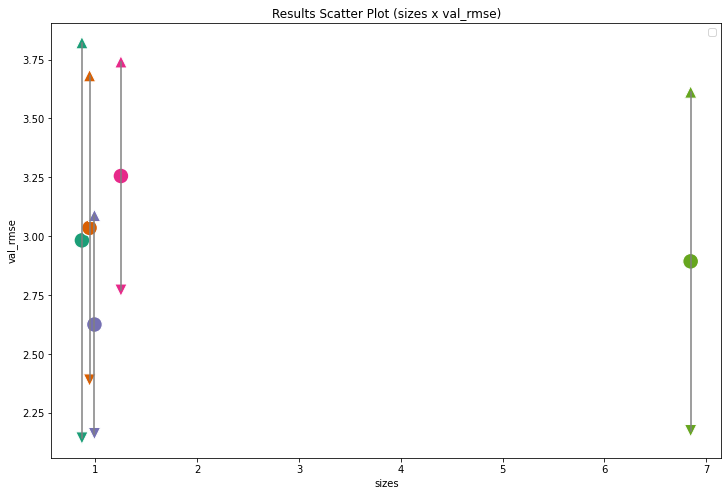

In [76]:
utils.plot_scatter_results(results_df=results_df, std_df=std_df, x='sizes', y='val_rmse')

## Visualize the results

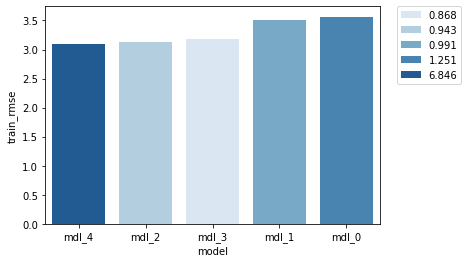

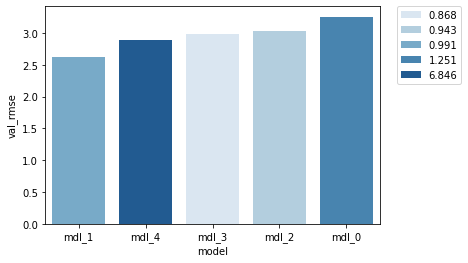

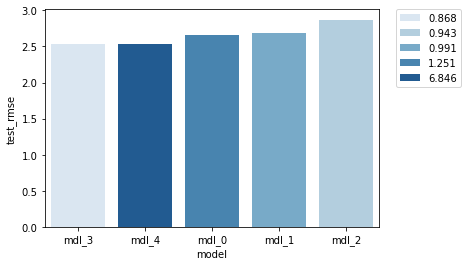

In [25]:
y = 'train_rmse'
results_df = results_df.sort_values(by=[y])
sns.barplot(x=results_df['model'], y=y, data=results_df, hue='sizes', palette='Blues', dodge=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

y = 'val_rmse'
results_df = results_df.sort_values(by=[y])
sns.barplot(x=results_df['model'], y=y, data=results_df, hue='sizes', palette='Blues', dodge=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

y = 'test_rmse'
results_df = results_df.sort_values(by=[y])
sns.barplot(x=results_df['model'], y=y, data=results_df, hue='sizes', palette='Blues', dodge=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(traces[0][0]['medv'].values)
plt.plot(traces[0][1][:,0])
plt.show()

In [43]:
std_df

,train_loss,val_loss,test_loss,train_rmse,val_rmse,test_rmse,model
0,1.5408,3.1867,1.4062,0.2031,0.4843,0.2611,mdl_0
1,1.3044,2.6434,2.2637,0.1862,0.4627,0.3984,mdl_1
2,0.8506,4.3591,4.9006,0.1341,0.6455,0.7639,mdl_2
3,0.7788,5.8429,1.9958,0.1228,0.8385,0.3907,mdl_3
4,1.0045,5.0714,1.4535,0.1566,0.7182,0.2843,mdl_4
